In [2]:

% matplotlib notebook
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener
import math
import scipy

import json
from utils import *
from indicator_simulation import *


/Users/stranot/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<IPython.core.display.Javascript object>


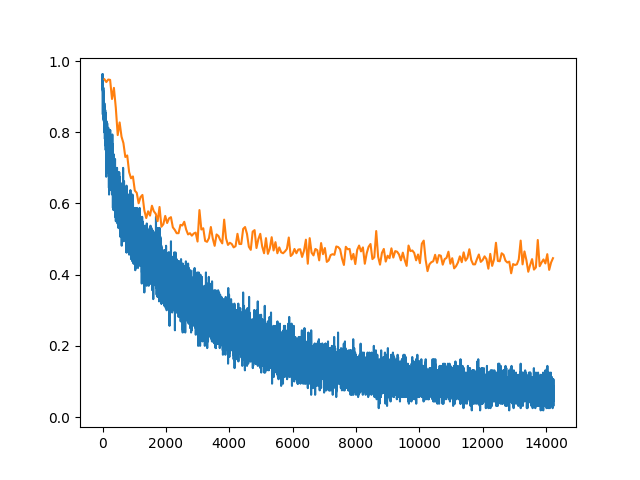

[   60   120   180   240   300   360   420   480   540   600   660   720
   780   840   900   960  1020  1080  1140  1200  1260  1320  1380  1440
  1500  1560  1620  1680  1740  1800  1860  1920  1980  2040  2100  2160
  2220  2280  2340  2400  2460  2520  2580  2640  2700  2760  2820  2880
  2940  3000  3060  3120  3180  3240  3300  3360  3420  3480  3540  3600
  3660  3720  3780  3840  3900  3960  4020  4080  4140  4200  4260  4320
  4380  4440  4500  4560  4620  4680  4740  4800  4860  4920  4980  5040
  5100  5160  5220  5280  5340  5400  5460  5520  5580  5640  5700  5760
  5820  5880  5940  6000  6060  6120  6180  6240  6300  6360  6420  6480
  6540  6600  6660  6720  6780  6840  6900  6960  7020  7080  7140  7200
  7260  7320  7380  7440  7500  7560  7620  7680  7740  7800  7860  7920
  7980  8040  8100  8160  8220  8280  8340  8400  8460  8520  8580  8640
  8700  8760  8820  8880  8940  9000  9060  9120  9180  9240  9300  9360
  9420  9480  9540  9600  9660  9720  9780  9840  9

In [65]:
# read train data
event_file = 'data/imagenet/imagenet_train_summary_1/train'
relative_time = []
train_epochs = []
train_err = []
summary = tf.train.summary_iterator(event_file)
for i, e in enumerate(summary):
    for v in e.summary.value:
        if v.tag == 'train_accuracy_1':
            train_epochs.append(e.step)
            train_err.append(1-v.simple_value)

plt.figure()
plt.plot(train_epochs, train_err)

# read eval data
event_file = 'data/imagenet/imagenet_train_summary_1/eval'
# event_file = 'data/bs_32_eval'
# event_file = 'data/eval_wo_lr_decay'
relative_time = []
eval_epochs = []
eval_err = []
summary = tf.train.summary_iterator(event_file)
for i, e in enumerate(summary):
    for v in e.summary.value:
        if v.tag == 'accuracy':
            eval_epochs.append(e.step)
            eval_err.append(1-v.simple_value)
# val_err = eval_err
# val_epochs = eval_epochs

# """
# Ignore the first part where evals are more intensive when getting the ground truch early stopping epoch
# """

# # get the begin point after which the num_epochs_between_eval never changes anymore
# e_ref = eval_epochs[0]
# diff = eval_epochs[1] - e_ref
# for i,e in enumerate(eval_epochs[1:]):
#     if e - e_ref == diff:
#         e_ref = e
#     else:
#         switch_point = i + 1
#         switch_epoch = e
#         break
# # print(switch_point,switch_epoch, eval_epochs_[switch_point], eval_epochs_[switch_point-1], eval_epochs_[switch_point+1])

# # delete the replicated values and the final one and the first one
# eval_epochs.pop(switch_point)
# eval_epochs.pop(-1)
eval_epochs.pop(0)
eval_epochs = np.array(eval_epochs)
# eval_err.pop(switch_point)
# eval_err.pop(-1)
# eval_err.pop(0)
eval_err = np.array(eval_err)
# switch_epoch = eval_epochs[switch_point]
# print(switch_epoch)

# sample_point = np.arange(0, switch_point//5)
# # print(sample_point)
# sample_point = np.array([int(s)+1 for s in sample_point])*5-1
# # print(sample_point)
# # sample_epochs = eval_epochs[sample_point] 
# # print(sample_epochs)
# val_epochs = np.concatenate([eval_epochs[sample_point], eval_epochs[switch_point:]])
# val_err = np.concatenate([eval_err[sample_point], eval_err[switch_point:]])

sample_point = np.arange(0, len(eval_epochs)//3)
sample_point = np.array([int(s)+1 for s in sample_point])*3-1
val_epochs = eval_epochs[sample_point]
val_err = eval_err[sample_point]
plt.plot(val_epochs, val_err)


dict_ = {'train_epochs': train_epochs, 
         'train_err': train_err, 
         'val_epochs': list(float(v) for v in val_epochs), 
         'val_err':list(float(v) for v in val_err)}
# store as jsons file
with open('jsons/imagenet_train_summary_1.json', 'w') as f:
    json.dump(dict_,f)
    
print(val_epochs)

In [4]:
err = np.array(eval_err)
epochs = np.array(eval_epochs)
bnds = ((0, None), (None, 0), (None,None))
inits = (1,0,0)

a, b = power_regression(epochs, err, weights = np.ones(len(epochs)))
d = 0
# a = rst.x[0]
# b = rst.x[1]
# c = rst.x[2]
plt.figure()
plt.plot(epochs, err)
plt.plot(epochs, a*np.power(epochs, b))
# plt.plot(train_epochs, np.exp(-a*(train_epochs+b))+c)

var = np.var(a*np.power(epochs[len(epochs)-300:], b) - err[len(epochs)-300:])


# min_delta = 5e-4
# patience = 15
# pred, stopping_epochs, sample, smoothed_sample = early_stopping_prediction_adding_noise(
#                                                                     a,b,d,0,var2,
#                                                                     min_delta,patience,
#                                                                      20,
#                                                                      55,
#                                                                      num_samples=100,
#                                                                      upper_limit=2e5,
#                                                                      lower_limit=epochs[-1],
#                                                                                      )
# print(pred)

end = 150
a0, b0 = power_regression(epochs[:end], err[:end], weights = np.ones(end))
d = 0
# a = rst.x[0]
# b = rst.x[1]
# c = rst.x[2]
plt.figure()
plt.plot(epochs, err)
plt.plot(epochs, a0*np.power(epochs, b0))
# plt.plot(train_epochs, np.exp(-a*(train_epochs+b))+c)
var2 = np.var(a0*np.power(epochs[:25], b0) - err[:25])
print(var, var2)
min_delta = 5e-4
patience = 10
# pred, stopping_epochs, sample, smoothed_sample = early_stopping_prediction_adding_noise(
#                                                                     a0,b0,d,0,var,
#                                                                     min_delta,patience,
#                                                                      20,
#                                                                      55,
#                                                                      num_samples=100,
#                                                                      upper_limit=2e5,
#                                                                      lower_limit=500,
#                                                                                      )


A = np.vstack([epochs[:end], np.ones(end)]).T
a1, b1 = np.linalg.lstsq(A, err[:end], rcond=-1)[0]
linear_end = math.floor(-b1/a1/20)
print(linear_end)
plt.plot(epochs[:linear_end], a1*epochs[:linear_end]+b1)

a2, b2 = power_regression(epochs[:linear_end], a1*epochs[:linear_end]+b1, weights = np.ones(linear_end))
a2, b2 = power_regression(np.arange(1,linear_end+1)*20, a1*np.arange(1,linear_end+1)*20+b1, weights = np.ones(linear_end))
plt.plot(epochs, a2*np.power(epochs, b2))
pred, stopping_epochs, sample, smoothed_sample = early_stopping_prediction_adding_noise(
                                                                    a2,b2,d,0,var2,
                                                                    min_delta,patience,
                                                                     20,
                                                                     55,
                                                                     num_samples=100,
                                                                     upper_limit=2e5,
                                                                     lower_limit=500,
                                                                                     )
print(pred)

/Users/stranot/qfdong/research/Early_stopping/simulate_online_regression/utils.py:78: RuntimeWarning: divide by zero encountered in log
  A = np.vstack([np.log(x)*weights, np.ones(len(x))*weights]).T


LinAlgError: SVD did not converge in Linear Least Squares

<IPython.core.display.Javascript object>


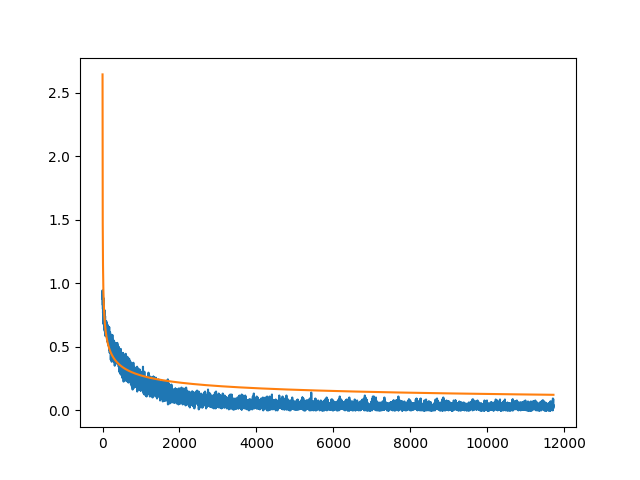

In [113]:
train_err = np.array(train_err)
train_epochs = np.array(train_epochs)
end = 1000
bnds = ((0, None), (None, 0), (None,None))
inits = (1,0,0)

# fun = lambda x: np.sum(np.power(train_err[:end]-(np.exp(x[1]*np.log(train_epochs[:end])+np.log(x[0]))),2))
# fun = lambda x: np.sum(np.power(train_err[:end]-(np.exp(-x[0]*(train_epochs[:end]+x[1]))+x[2]),2))
# rst = scipy.optimize.minimize(fun, inits, method='TNC', bounds=bnds)
a, b = power_regression(train_epochs[:end], train_err[:end], weights = np.ones(end))
# a = rst.x[0]
# b = rst.x[1]
# c = rst.x[2]
plt.figure()
plt.plot(train_epochs, train_err)
plt.plot(train_epochs, a*np.power(train_epochs, b))
# plt.plot(train_epochs, np.exp(-a*(train_epochs+b))+c)

<IPython.core.display.Javascript object>


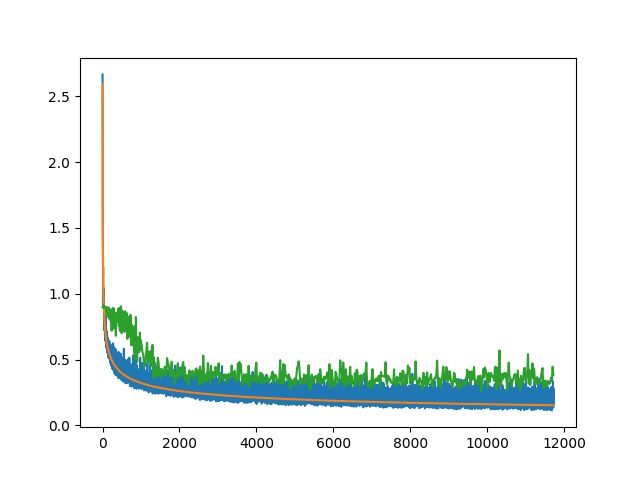

In [126]:
plt.figure()
var = 0.01
num_points = len(train_epochs)
noise = np.random.rayleigh(np.sqrt((4-np.pi)/2*var), num_points) - var*np.sqrt(np.pi/2)
values = a*np.power(train_epochs, b)+noise
plt.plot(train_epochs, values)
end = 100
a1, b1 = power_regression(train_epochs[:end], values[:end], weights = np.ones(end))
plt.plot(train_epochs, a1*np.power(train_epochs, b1))
